In [254]:
using ModelingToolkit
using OrdinaryDiffEq
using DifferentialEquations
using AlgebraicPetri
using AlgebraicPetri.Epidemiology
using AlgebraicPetri.BilayerNetworks

using Plots
using Random

using Catlab
using Catlab.CategoricalAlgebra
using Catlab.Graphics
import Catlab.CategoricalAlgebra: migrate!
using Catlab.WiringDiagrams
using Catlab.Programs.RelationalPrograms

using JSON

using Dates

In [255]:
make_depvar(p,t) = :($p($t))

make_depvar (generic function with 1 method)

In [256]:
function compile(bn::Union{AbstractLabelledBilayerNetwork, AbstractBilayerNetwork})
  varstmt = :(@variables t)
  varnames = bn[:variable]
  append!(varstmt.args, make_depvar.(bn[:variable], :t))

  paramstmt = :(@parameters)
  params = bn[:parameter]
  append!(paramstmt.args, bn[:parameter])

  diffstmt = :(_D_ = Differential(t))

  ϕs = map(parts(bn, :Box)) do b
    vars = map(incident(bn, b,:call)) do i
      j = bn[i, :arg]
      return bn[j, :variable]
    end
    p = :(*($(bn[b, :parameter])))
    append!(p.args, vars)
    return :($(Symbol("ϕ$b")) = $p)
  end

  infs = map(parts(bn, :Qout)) do tv
    vars = map(incident(bn, tv, :infusion)) do wa
      j = bn[wa, :influx]
      return Symbol("ϕ$j")
    end
    p = :(+())
    append!(p.args, vars)

    # same for the outfluxes
    vars = map(incident(bn, tv, :effusion)) do wn
      j = bn[wn, :efflux]
      return :(- $(Symbol("ϕ$j")))
    end
    append!(p.args, vars)
    return p
  end

  zparts = zip(bn[:tanvar], infs)

  eqns = [:(_D_($tanvar) ~ $rhs) for (tanvar, rhs) in zparts]
  eq = :([])
  append!(eq.args, eqns)
  eqnstmt = :(eqs = $eq)

  varnameexpr = Expr(:tuple, varnames...)
  parnameexpr = Expr(:tuple, params...)

  return quote
    $varstmt
    $paramstmt
    $diffstmt
    $(ϕs...)
    $eqnstmt
    return $varnameexpr, $parnameexpr, ODESystem(eqs, t, name=:PetriNet)
  end
end

compile (generic function with 1 method)

In [257]:
@present TheoryOrigMIRANet <: SchLabelledReactionNet begin
    MID::AttrType
    MCTX::AttrType
    Template::AttrType
    mira_ids::Attr(S, MID)
    mira_context::Attr(S, MCTX)
    mira_initial_value::Attr(S, Concentration)
    template_type::Attr(T, Template)
    parameter_name::Attr(T, Name)
    parameter_value::Attr(T, Rate)
end
@abstract_acset_type AbstractOrigMIRANet <: AbstractLabelledReactionNet
@acset_type OrigMIRANet(TheoryOrigMIRANet) <: AbstractOrigMIRANet

OrigMIRANet

In [258]:
function mtk_simulate(jsonfile, states, params, timespan)
    mira = read_json_acset(OrigMIRANet{Any,Any,Any,Any,Any,Any}, jsonfile)
    map!(Symbol, mira[:sname], mira[:sname])
    map!(Symbol, mira[:tname], mira[:tname])
    bnsir = LabelledBilayerNetwork()
    migrate!(bnsir, LabelledPetriNet(mira))
    mdl = eval(compile(bnsir))
    prob = ODEProblem(mdl[3], states, timespan, params)
    soln = solve(prob)
    return soln
end

mtk_simulate (generic function with 1 method)

In [252]:
# Set RNG seed
Random.seed!(1234);

# Constants
num_timesteps = 60
timespan = (0, num_timesteps)
num_runs = 10

# Run simulation for every available model

for source in ["biomodels", "starter-kit"]

    for model_dir in readdir(joinpath("./thin-thread-examples", source), join = true)

        root, dirs, files = first(walkdir(model_dir))

        if "model_petri.json" in files

            p_model = joinpath(model_dir, "model_petri.json")
            model = JSON.parsefile(p_model)    
            num_states = length(model["S"])
            num_params = length(model["T"])

            # Iterate over runs
            for i_run in 0:num_runs

                # Run with default values in model
                if i_run == 0

                    mmt_params = JSON.parsefile(joinpath(model_dir, "model_mmt_parameters.json"))
                    mmt_initials = JSON.parsefile(joinpath(model_dir, "model_mmt_initials.json"))

                    # Get default model parameter values
                    params = Vector{Float64}(undef, length(model["T"]))
                    for i in 1:length(model["T"])    
                        if ~isnothing(model["T"][i]["parameter_value"])
                            if typeof(model["T"][i]["parameter_value"]) == typeof(params[i])
                                params[i] = model["T"][i]["parameter_value"]
                            else
                                params[i] = parse(Float64, model["T"][i]["parameter_value"])
                            end
                        else
                            params[i] = 0.0
                        end
                    end

                    # Get default initial condition values
                    initials = Vector{Float64}(undef, length(model["S"]))
                    for i in 1:length(model["S"])
                        if "mira_initial_value" in keys(model["S"][i])
                            if ~isnothing(model["S"][i]["mira_initial_value"])
                                if typeof(model["S"][i]["mira_initial_value"]) == typeof(initials[i])
                                    initials[i] = model["S"][i]["mira_initial_value"]
                                else
                                    initials[i] = parse(Float64, model["S"][i]["mira_initial_value"])
                                end
                            else
                                initials[i] = 0.0
                            end
                        else
                            initials[i] = 0.0
                        end
                    end

                # Run with random values
                else

                    initials = rand(num_states)
                    initials = initials / sum(initials)
                    
                    params = rand(num_params)

                end

                # Run simulation
                soln = mtk_simulate(p_model, initials, params, timespan)

                # Map results to output format  
                output = deepcopy(mmt_initials["initials"])
                for i in 1:length(model["S"])
                    output[model["S"][i]["sname"]]["value"] = Vector{Float64}(undef, length(soln.t))
                    for t in 1:length(soln.t)
                        output[model["S"][i]["sname"]]["value"][t] = soln.u[t][i]
                    end
                end

                # Time
                df = Dates.DateFormat("yyyy-mm-ddTHH:MM:SS")
                start_datetime = DateTime(2022, 1, 1, 0, 0)
                delta = DateTime(2022, 1, 2, 0, 0) - DateTime(2022, 1, 1, 0, 0)
                output["_time"] = Dict("name" => "time", "identifiers" => Dict(), "context" => Dict(), "value" => Vector{String}(undef, length(soln.t)))

                for t in 1:length(soln.t)
                    output["_time"]["value"][t] = Dates.format(start_datetime + delta * (t - 1), df)
                end

                # Convert `params` to MIRA file format
                params_data = Dict("parameters" => Dict())
                for i in 1:length(model["T"])
                    k = model["T"][i]["parameter_name"]
                    if k in keys(mmt_params["parameters"])
                        params_data["parameters"][k] = mmt_params["parameters"][k]
                        params_data["parameters"][k]["value"] = params[i]
                    else
                        params_data["parameters"][model["T"][i]["tname"]] = Dict("name" => k, "identifiers" => Dict(), "context" => Dict(), "value" => params[i])
                    end
                end

                # Convert `initials` to MIRA file format
                initials_data = Dict("initials" => Dict())
                for i in 1:length(model["S"])
                    k = model["S"][i]["sname"]
                    if k in keys(mmt_initials["initials"])
                        initials_data["initials"][k] = mmt_initials["initials"][k]
                        initials_data["initials"][k]["value"] = initials[i]
                    else
                        initials_data["initials"][k] = Dict("name" => k, "identifiers" => Dict(), "context" => Dict(), "value" => initials[i])
                    end
                end 
                
                # Make output directory
                dir_name = string(i_run)
                p_output = joinpath(model_dir, "runs", dir_name)
                if ~isdir(p_output)
                    mkpath(p_output)
                end
                
                # Serialize and write to file
                open(joinpath(p_output, "parameters.json"), "w") do f
                    JSON.print(f, params_data)
                end

                open(joinpath(p_output, "initials.json"), "w") do f
                    JSON.print(f, initials_data)
                end

                open(joinpath(p_output, "output.json"), "w") do f
                    JSON.print(f, output)
                end

            end

            print("Success: $model_dir\n")

        else

            print("Error: missing `model_petri.json` in $model_dir\n")

        end
    end
end

Success: ./thin-thread-examples/biomodels/BIOMD0000000955
Success: ./thin-thread-examples/biomodels/BIOMD0000000956
Success: ./thin-thread-examples/biomodels/BIOMD0000000957
Success: ./thin-thread-examples/biomodels/BIOMD0000000958
Success: ./thin-thread-examples/biomodels/BIOMD0000000960
Success: ./thin-thread-examples/biomodels/BIOMD0000000962
Success: ./thin-thread-examples/biomodels/BIOMD0000000963
Success: ./thin-thread-examples/biomodels/BIOMD0000000964
Success: ./thin-thread-examples/biomodels/BIOMD0000000969
Success: ./thin-thread-examples/biomodels/BIOMD0000000970
Success: ./thin-thread-examples/biomodels/BIOMD0000000971
Success: ./thin-thread-examples/biomodels/BIOMD0000000972
Success: ./thin-thread-examples/biomodels/BIOMD0000000974
Success: ./thin-thread-examples/biomodels/BIOMD0000000976
Success: ./thin-thread-examples/biomodels/BIOMD0000000977
Success: ./thin-thread-examples/biomodels/BIOMD0000000978
Success: ./thin-thread-examples/biomodels/BIOMD0000000979
Success: ./thi

In [ ]:
# Specific scenarios to run for BIOMD0000000955 (SIDARTHE):
# 1. (Baseline) α = 0.57, β = 0.011, γ = 0.456, δ = 0.0011, ε = 0.171, θ = 0.011, ...
# 2. (Fig. 3a,b; R0 = 0.98; weaker social distancing by decreasing alpha) α = 0.252
# 3. (Fig. 3c,d; R0 = 0.50; stronger social distancing by decreasing alpha more) α = 0.105
# 4. (Fig. 4a,b; R0 = 0.59; stronger testing & contact tracing by increasing epsilon) ε = 0.400
# 5. (Fig. 4c,d; R0 = 0.77; mild social distancing & very strong testing & contract tracing by decreasing epsilon) α = 0.420, ε = 0.600
# 6. (Extended Data Fig. 1a,b; R0 = 1.66; no social distancing) α = 0.422, β = 0.0057, γ = 0.285, δ = 0.0057
# 7. (Extended Data Fig. 1c,d; R0 = 1.13; mild social distancing) α = 0.285, γ = 0.171
# 8. (Extended Data Fig. 1e,f; R0 = 0.79; strong social-distancing) α = 0.200, γ = 0.086
# 9. (Extended Data Fig. 1g,h; R0 = 0.033; very strong social-distancing) α = 0.057, γ = 0.057

# Parameter meaning:
# α: transmission rate between S and I
# β: transmission rate between S and D
# γ: transmission rate between S and A
# δ: transmission rate between S and R
# ε: detection rate of asymptomatic cases
# θ: detection rate of symptomatic cases
# ...

In [334]:
# Get model
model_dir = "./thin-thread-examples/demo/BIOMD0000000955"
p_model = joinpath(model_dir, "model_petri.json")
model = JSON.parsefile(p_model)
num_states = length(model["S"])
num_params = length(model["T"])

print("Number of State Variables = $num_states\n")
print("Number of Parameters = $num_params\n")

Number of State Variables = 8
Number of Parameters = 16


In [339]:
mira = read_json_acset(OrigMIRANet{Any,Any,Any,Any,Any,Any}, p_model)

T,rate,tname,template_type,parameter_name,parameter_value
1,#undef,t1,ControlledConversion,alpha,0.57
2,#undef,t2,ControlledConversion,beta,0.011
3,#undef,t3,ControlledConversion,gamma,0.456
4,#undef,t4,ControlledConversion,delta,0.011
5,#undef,t5,NaturalConversion,epsilon,0.171
6,#undef,t6,NaturalConversion,zeta,0.125
7,#undef,t7,NaturalConversion,lambda,0.034
8,#undef,t8,NaturalConversion,eta,0.125
9,#undef,t9,NaturalConversion,rho,0.034
10,#undef,t10,NaturalConversion,theta,0.371


In [335]:
# Define scenario parameters
# params = [alpha, beta, gamma, delta, epsilon, zeta, lambda, eta, rho, theta, kappa, mu, nu, xi, tau, sigma]

num_scenarios = 9
params = Array{Float64, 2}(undef, num_scenarios, num_params)

params[1, :] = [0.570, 0.011, 0.456, 0.0011, 0.171, 0.125, 0.034, 0.125, 0.034, 0.371, 0.017, 0.017, 0.027, 0.017, 0.01, 0.017]
params[2, :] = [0.252, 0.011, 0.456, 0.0011, 0.171, 0.125, 0.034, 0.125, 0.034, 0.371, 0.017, 0.017, 0.027, 0.017, 0.01, 0.017]
params[3, :] = [0.105, 0.011, 0.456, 0.0011, 0.171, 0.125, 0.034, 0.125, 0.034, 0.371, 0.017, 0.017, 0.027, 0.017, 0.01, 0.017]
params[4, :] = [0.570, 0.011, 0.456, 0.0011, 0.400, 0.125, 0.034, 0.125, 0.034, 0.371, 0.017, 0.017, 0.027, 0.017, 0.01, 0.017]
params[5, :] = [0.420, 0.011, 0.456, 0.0011, 0.600, 0.125, 0.034, 0.125, 0.034, 0.371, 0.017, 0.017, 0.027, 0.017, 0.01, 0.017]
params[6, :] = [0.422, 0.0057, 0.286, 0.0057, 0.171, 0.125, 0.034, 0.125, 0.034, 0.371, 0.017, 0.017, 0.027, 0.017, 0.01, 0.017]
params[7, :] = [0.285, 0.011, 0.171, 0.0011, 0.171, 0.125, 0.034, 0.125, 0.034, 0.371, 0.017, 0.017, 0.027, 0.017, 0.01, 0.017]
params[8, :] = [0.200, 0.011, 0.086, 0.0011, 0.171, 0.125, 0.034, 0.125, 0.034, 0.371, 0.017, 0.017, 0.027, 0.017, 0.01, 0.017]
params[9, :] = [0.057, 0.011, 0.057, 0.0011, 0.171, 0.125, 0.034, 0.125, 0.034, 0.371, 0.017, 0.017, 0.027, 0.017, 0.01, 0.017]

16-element Vector{Float64}:
 0.057
 0.011
 0.057
 0.0011
 0.171
 0.125
 0.034
 0.125
 0.034
 0.371
 0.017
 0.017
 0.027
 0.017
 0.01
 0.017

In [340]:
# Get default initial condition values
initials = Vector{Float64}(undef, length(model["S"]))
for i in 1:length(model["S"])
    if "mira_initial_value" in keys(model["S"][i])
        if ~isnothing(model["S"][i]["mira_initial_value"])
            if typeof(model["S"][i]["mira_initial_value"]) == typeof(initials[i])
                initials[i] = model["S"][i]["mira_initial_value"]
            else
                initials[i] = parse(Float64, model["S"][i]["mira_initial_value"])
            end
        else
            initials[i] = 0.0
        end
    else
        initials[i] = 0.0
    end
end

In [367]:
initials_

8-element Vector{Float64}:
 0.7290393665032278
 0.24301402107660747
 0.024301402107660745
 0.0012150701017378269
 0.0024301402107660746
 0.0
 0.0
 0.0

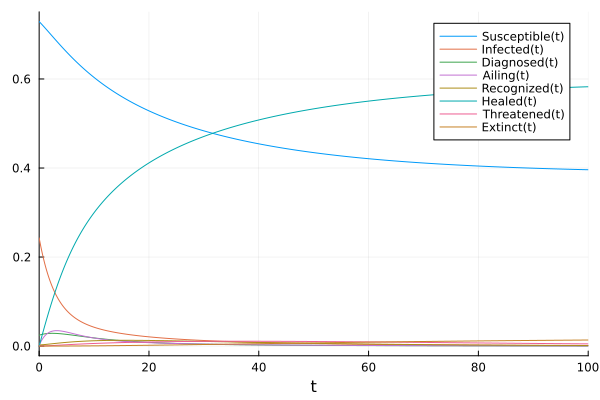

In [376]:
# Trial run
# Need to increase the initial Infected relative population to see any meaningful dynamics?

initials_ = deepcopy(initials)
initials_[2:end] = 1e5 * initials_[2:end]
initials_ = initials_ / sum(initials_)

soln = mtk_simulate(p_model, initials_, params[1, :], (0, 100))
plot(soln)

In [377]:
# Run scenarios

mmt_params = JSON.parsefile(joinpath(model_dir, "model_mmt_parameters.json"))
mmt_initials = JSON.parsefile(joinpath(model_dir, "model_mmt_initials.json"))

for i_scenario in 1:num_scenarios

    # Run simulation
    soln = mtk_simulate(p_model, initials_, params[i_scenario, :], timespan)

    # Map results to output format  
    output = deepcopy(mmt_initials["initials"])
    for i in 1:length(model["S"])
        output[model["S"][i]["sname"]]["value"] = Vector{Float64}(undef, length(soln.t))
        for t in 1:length(soln.t)
            output[model["S"][i]["sname"]]["value"][t] = soln.u[t][i]
        end
    end

    # Time
    df = Dates.DateFormat("yyyy-mm-ddTHH:MM:SS")
    start_datetime = DateTime(2022, 1, 1, 0, 0)
    delta = DateTime(2022, 1, 2, 0, 0) - DateTime(2022, 1, 1, 0, 0)
    output["_time"] = Dict("name" => "time", "identifiers" => Dict(), "context" => Dict(), "value" => Vector{String}(undef, length(soln.t)))

    for t in 1:length(soln.t)
        output["_time"]["value"][t] = Dates.format(start_datetime + delta * (t - 1), df)
    end

    # Convert `params` to MIRA file format
    params_data = Dict("parameters" => Dict())
    for i in 1:length(model["T"])
        k = model["T"][i]["parameter_name"]
        if k in keys(mmt_params["parameters"])
            params_data["parameters"][k] = mmt_params["parameters"][k]
            params_data["parameters"][k]["value"] = params[i]
        else
            params_data["parameters"][model["T"][i]["tname"]] = Dict("name" => k, "identifiers" => Dict(), "context" => Dict(), "value" => params[i])
        end
    end

    # Convert `initials` to MIRA file format
    initials_data = Dict("initials" => Dict())
    for i in 1:length(model["S"])
        k = model["S"][i]["sname"]
        if k in keys(mmt_initials["initials"])
            initials_data["initials"][k] = mmt_initials["initials"][k]
            initials_data["initials"][k]["value"] = initials_[i]
        else
            initials_data["initials"][k] = Dict("name" => k, "identifiers" => Dict(), "context" => Dict(), "value" => initials[i])
        end
    end 

    # Make output directory
    dir_name = string(i_run)
    p_output = joinpath(model_dir, "runs", dir_name)
    if ~isdir(p_output)
        mkpath(p_output)
    end

    # Serialize and write to file
    open(joinpath(p_output, "parameters.json"), "w") do f
        JSON.print(f, params_data)
    end

    open(joinpath(p_output, "initials.json"), "w") do f
        JSON.print(f, initials_data)
    end

    open(joinpath(p_output, "output.json"), "w") do f
        JSON.print(f, output)
    end
    
end